In [4]:
using MAT
using Images, FileIO
using Knet

In [5]:
include("mpii.annotation.reader.jl")
include("../helper.jl")
include("../models.jl")
include("loss.jl")
include("../utils.jl")
include("visualizer.jl")

draw_body_skeleton (generic function with 1 method)

In [192]:
groups_path = "/userfiles/gsoykan20/mpii_human_pose/groups_v12.mat/groups_v12.mat"
file = matopen(groups_path)
dataset_groups = read(file, "groups")
close(file)

In [196]:
dataset_groups;

In [166]:
original_annotations_path_up = "/datasets/mpii_human_pose/mpii_human_pose_v1_u12_1.mat"
file = matopen(original_annotations_path_up)
original_annotations_up = read(file, "RELEASE")
close(file);

In [173]:
original_annotations_up["annolist"]["annorect"][1, 1]

Dict{String,Any} with 2 entries:
  "objpos" => Dict{String,Any}("x"=>601.0,"y"=>380.0)
  "scale"  => 3.88073

In [49]:
original_annotations_path = "/datasets/mpii_human_pose/u12_2/mpii_human_pose_v1_u12_1.mat"
file = matopen(original_annotations_path)
original_annotations = read(file, "RELEASE")
close(file);

In [137]:
test_idxs = findall(e -> e == 0 ,original_annotations["img_train"]);
test_idxs_reversed = map(e -> CartesianIndex(e[2], e[1]), test_idxs);

In [180]:
train_idxs = findall(e -> e == 1 ,original_annotations["img_train"])

18079-element Array{CartesianIndex{2},1}:
 CartesianIndex(1, 5)
 CartesianIndex(1, 6)
 CartesianIndex(1, 7)
 CartesianIndex(1, 8)
 CartesianIndex(1, 9)
 CartesianIndex(1, 10)
 CartesianIndex(1, 11)
 CartesianIndex(1, 14)
 CartesianIndex(1, 15)
 CartesianIndex(1, 16)
 CartesianIndex(1, 17)
 CartesianIndex(1, 18)
 CartesianIndex(1, 19)
 ⋮
 CartesianIndex(1, 24963)
 CartesianIndex(1, 24975)
 CartesianIndex(1, 24976)
 CartesianIndex(1, 24977)
 CartesianIndex(1, 24978)
 CartesianIndex(1, 24979)
 CartesianIndex(1, 24980)
 CartesianIndex(1, 24981)
 CartesianIndex(1, 24982)
 CartesianIndex(1, 24983)
 CartesianIndex(1, 24984)
 CartesianIndex(1, 24985)

In [138]:
# 26432
#filter( e -> e == 1 ,original_annotations["img_train"])
#original_annotations["annolist"]["image"]
single_person_idxs = findall(e -> !isempty(e) ,original_annotations["single_person"])
single_person_test_idxs = filter(e -> e in test_idxs_reversed, single_person_idxs)

5709-element Array{CartesianIndex{2},1}:
 CartesianIndex(1, 1)
 CartesianIndex(3, 1)
 CartesianIndex(4, 1)
 CartesianIndex(12, 1)
 CartesianIndex(13, 1)
 CartesianIndex(26, 1)
 CartesianIndex(27, 1)
 CartesianIndex(60, 1)
 CartesianIndex(61, 1)
 CartesianIndex(62, 1)
 CartesianIndex(66, 1)
 CartesianIndex(67, 1)
 CartesianIndex(68, 1)
 ⋮
 CartesianIndex(24958, 1)
 CartesianIndex(24964, 1)
 CartesianIndex(24965, 1)
 CartesianIndex(24966, 1)
 CartesianIndex(24967, 1)
 CartesianIndex(24968, 1)
 CartesianIndex(24969, 1)
 CartesianIndex(24970, 1)
 CartesianIndex(24971, 1)
 CartesianIndex(24972, 1)
 CartesianIndex(24973, 1)
 CartesianIndex(24974, 1)

In [155]:
#=
.annorect(ridx) - body annotations for a person ridx
.x1, .y1, .x2, .y2 - coordinates of the head rectangle
.scale - person scale w.r.t. 200 px height
.objpos - rough human position in the image
.annopoints.point - person-centric body joint annotations
.x, .y - coordinates of a joint
id - joint id (0 - r ankle, 1 - r knee, 2 - r hip, 3 - l hip, 4 - l knee, 5 - l ankle, 6 - pelvis, 7 - thorax, 8 - upper neck, 9 - head top, 10 - r wrist, 11 - r elbow, 12 - r shoulder, 13 - l shoulder, 14 - l elbow, 15 - l wrist)
is_visible - joint visibility
=#

In [144]:
single_person_test_images_path = vec(original_annotations["annolist"]["image"])[single_person_test_idxs];
single_person_test_images_path = map(e -> e["name"] ,single_person_test_images_path);

In [181]:
original_annotations["annolist"]["annorect"][1, 5]

Dict{String,Any} with 7 entries:
  "objpos"     => Any[Dict{String,Any}("x"=>594.0,"y"=>257.0) Dict{String,Any}(…
  "x1"         => Any[627.0 841.0]
  "y1"         => Any[100.0 145.0]
  "annopoints" => Any[Dict{String,Any}("point"=>Dict{String,Any}("x"=>Any[610.0…
  "x2"         => Any[706.0 902.0]
  "y2"         => Any[198.0 228.0]
  "scale"      => Any[3.02105 2.47212]

In [ ]:
# annolist_test = annolist(RELEASE.img_train == 0);
# rectidxs = RELEASE.single_person(RELEASE.img_train == 0);

In [ ]:
path_to_processed_mat = "/userfiles/gsoykan20/mpii_human_pose/cropped/dataset.mat"

In [32]:
file = matopen(path_to_processed_mat)
dataset = read(file, "dataset")
close(file);

In [34]:
dataset["image"][1, ]

1×28883 Array{Any,2}:
 "/userfiles/gsoykan20/mpii_human_pose/cropped/im00005_1.png"  …  "/userfiles/gsoykan20/mpii_human_pose/cropped/im24985_4.png"

In [76]:
path_to_single_person_mat = (
    "/userfiles/gsoykan20/mpii_human_pose/cropped/annolist-singlePerson-h400.mat"
)
path_to_full_mat = "/userfiles/gsoykan20/mpii_human_pose/cropped/annolist-full-h400.mat"
path_to_multi_person_mat = (
    "/userfiles/gsoykan20/mpii_human_pose/cropped/annolist-multPerson-h400.mat"
)

"/userfiles/gsoykan20/mpii_human_pose/cropped/annolist-multPerson-h400.mat"

In [36]:
file = matopen(path_to_single_person_mat)
single_person = read(file)
close(file);

In [37]:
file = matopen(path_to_full_mat)
full_people = read(file)
close(file);

In [77]:
file = matopen(path_to_multi_person_mat)
multi_person = read(file)
close(file);

In [47]:
full_people["annolist"]["image"][1, 2]

Dict{String,Any} with 1 entry:
  "name" => "/userfiles/gsoykan20/mpii_human_pose/cropped/im00005_2.png"

In [48]:
single_person["annolist"]["image"][1, 2]

Dict{String,Any} with 1 entry:
  "name" => "/userfiles/gsoykan20/mpii_human_pose/cropped/im00005_2.png"

In [ ]:
image_path_from_dataset = dataset["image"][1, 20000]

In [ ]:
full_people["annolist"]["image"]

In [ ]:
single_person

In [ ]:
image_paths = map(x -> x["name"], multi_person["annolist"]["image"])
image_paths = vec(image_paths);
found_idx = findlast(x -> x == image_path_from_dataset ,image_paths)
println(found_idx)

In [ ]:
single_person["annolist"]["annorect"][1, 15]

In [ ]:
#  TODO: continue from here
single_person["annolist"]["image"]

In [ ]:
multi_person["annolist"]

In [ ]:
full_people["annolist"]["image"]

In [ ]:
test_image_path = multi_person["annolist"]["image"][1, 815]["name"]

In [ ]:
multi_person["annolist"]["annorect"][1, 815]

In [ ]:
test_img = load(test_image_path)

In [ ]:
size(test_img)

In [ ]:
cropped_dataset = read_cropped_mpii_annotations(;should_shuffle=false)

In [ ]:
cropped_dataset["annorect"][1]

In [ ]:
image_metas = find_annorect_and_is_single_info(cropped_dataset["image"]);

In [ ]:
image_metas[:, 2][1]

In [6]:
dval_29 = Knet.load("29-12-20-dval.jld2", "29-12-20-dval")
val_data_items_29 = Knet.load("29-12-20-val_data_items.jld2", "29-12-20-val_data_items");

deeper_cut_with_loc_ref = Knet.load("29-12-20-continue-training_model.jld2", "29-12-20-continue-training_model");

clear_gpu_memory()

dval_29_x = Knet.atype()(reshape(dval_29.x[:, 1:10], dval_29.xsize));
dval_29_y = Knet.atype()(reshape(dval_29.y[:, 1:10], dval_29.ysize));

output = deeper_cut_with_loc_ref(dval_29_x); # 64×64×70×10
output[: , : , 1:global_num_joints, : ] = sigm.(output[: , : , 1:global_num_joints, : ] );
output = Array(output);

#draw_score_maps( output[:, : ,: , 1] ) ;
#test_image  =Array(dval_29_x[:, :,:, 4]);
# display.(display_deepercut_input_image(test_image))

Effective GPU memory usage: 82.48% (12.170 GiB/14.756 GiB)
CUDA allocator usage: 315.280 MiB
binned usage: 6.875 KiB (6.875 KiB allocated, 0 bytes cached)
Discrepancy of 315.274 MiB between memory pool and allocator!


In [200]:
 dataset = read_cropped_mpii_annotations(; should_shuffle = false)

Dict{String,Any} with 5 entries:
  "image"     => ["/userfiles/gsoykan20/mpii_human_pose/cropped/im00005_1.png",…
  "annorect"  => Any[Dict{String,Any}("objpos"=>Dict{String,Any}("x"=>158.241,"…
  "size"      => [[3.0 391.0 295.0], [3.0 446.0 368.0], [3.0 252.0 170.0], [3.0…
  "joints"    => Array{Any,2}[[Int32[0 175 261; 1 173 178; … ; 12 187 126; 13 2…
  "is_single" => Any[true, true, true, true, true, true, true, true, true, true…

In [238]:
jd = Dict()

for j in dataset["joints"]
   for i in j[1][:,1, 1 ]
        
        jd[i + 1] = get(jd, i + 1, 0) + 1 
    end
end
jd |> printstyled

Dict{Any,Any}(2 => 24330,11 => 28653,7 => 28563,9 => 28776,10 => 28768,8 => 28665,6 => 20772,4 => 28218,3 => 28212,5 => 24344,13 => 28674,14 => 28673,12 => 28500,1 => 20773)

In [10]:
clear_gpu_memory()

Effective GPU memory usage: 81.60% (12.041 GiB/14.756 GiB)
CUDA allocator usage: 181.640 MiB
binned usage: 3.453 KiB (3.453 KiB allocated, 0 bytes cached)
Discrepancy of 181.637 MiB between memory pool and allocator!


In [16]:
include("visualizer.jl");

In [8]:
test_img = permutedims(Array(dval_29_x[:, :,:, 1]), (3, 1, 2));

test_img_colored = colorview(RGB, test_img);
#test_img |> typeof

In [ ]:
clr = RGB{Float32}(0.2, 0.6 ,0.2)

In [ ]:
draw!(test_img_colored, LineSegment(1, 1, 160,160), clr  )
# TODO: continue with creating skeleton here

In [ ]:
test_img_colored

In [19]:
  for idx in 4:4
        idx |> typeof |> println
end

Int64
ERROR: a exception was thrown during kernel execution.
       Run Julia on debug level 2 for device stack traces.
ERROR: a exception was thrown during kernel execution.
       Run Julia on debug level 2 for device stack traces.
ERROR: a exception was thrown during kernel execution.
       Run Julia on debug level 2 for device stack traces.
ERROR: a exception was thrown during kernel execution.
       Run Julia on debug level 2 for device stack traces.
ERROR: a exception was thrown during kernel execution.
       Run Julia on debug level 2 for device stack traces.
ERROR: a exception was thrown during kernel execution.
       Run Julia on debug level 2 for device stack traces.
ERROR: a exception was thrown during kernel execution.
       Run Julia on debug level 2 for device stack traces.
ERROR: a exception was thrown during kernel execution.
       Run Julia on debug level 2 for device stack traces.
ERROR: a exception was thrown during kernel execution.
       Run Julia on debug l

Excessive output truncated after 541190 bytes.

In [26]:
findall(e -> e.is_single ,val_data_items_29)

2185-element Array{Int64,1}:
    1
    3
    4
    5
    6
    8
    9
   10
   12
   15
   17
   19
   20
    ⋮
 3271
 3272
 3273
 3274
 3276
 3277
 3278
 3279
 3280
 3281
 3282
 3283

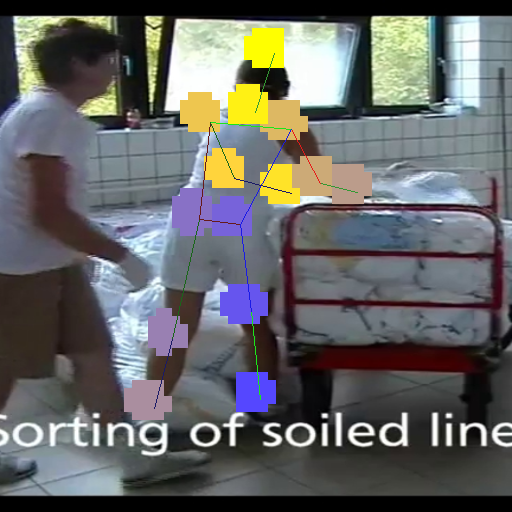

****** GROUND TRUTH ******


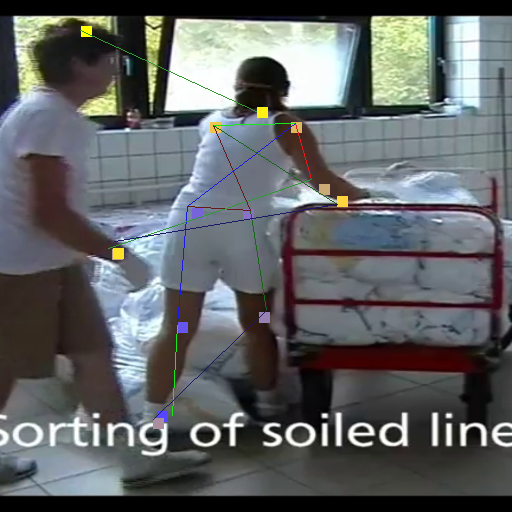

****** PART PREDICTIONS ******


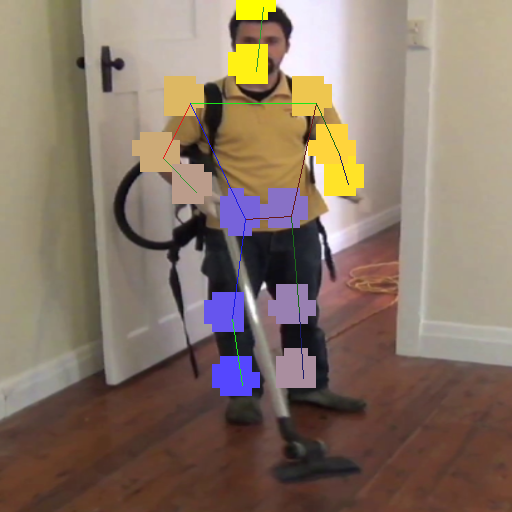

****** GROUND TRUTH ******


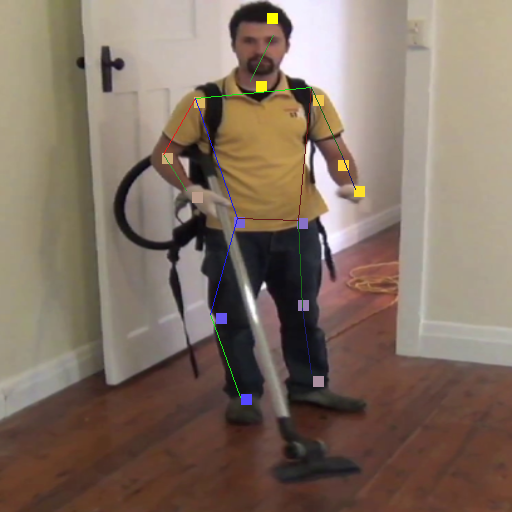

****** PART PREDICTIONS ******


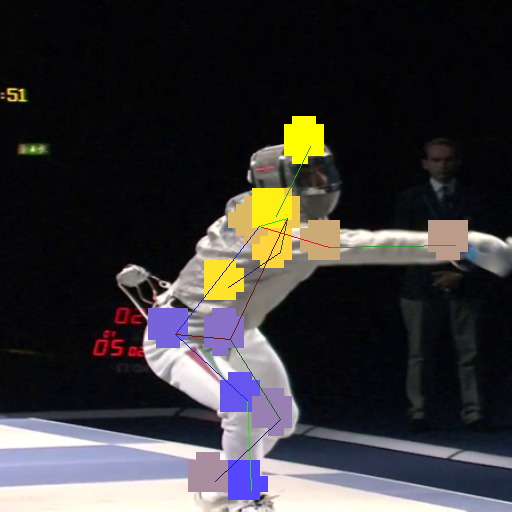

****** GROUND TRUTH ******


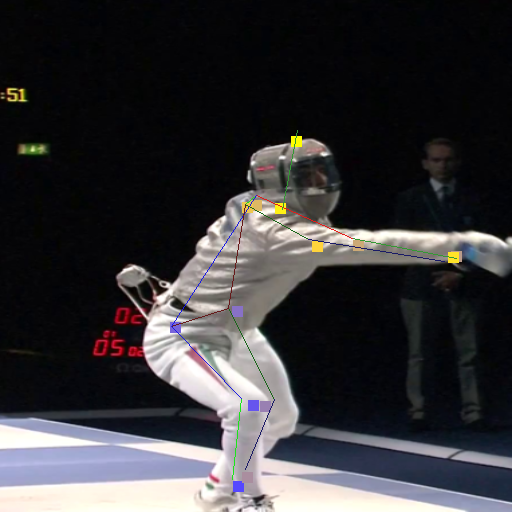

****** PART PREDICTIONS ******


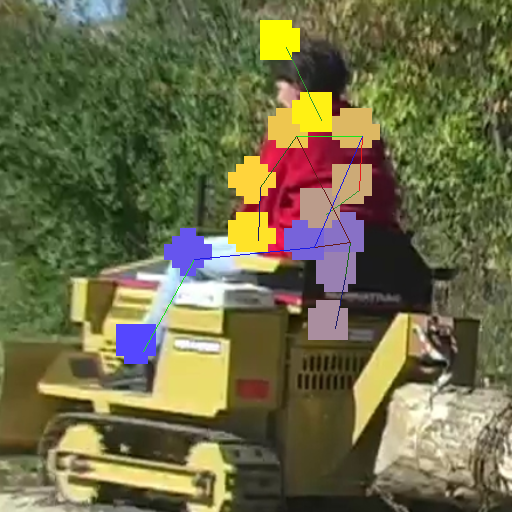

****** GROUND TRUTH ******


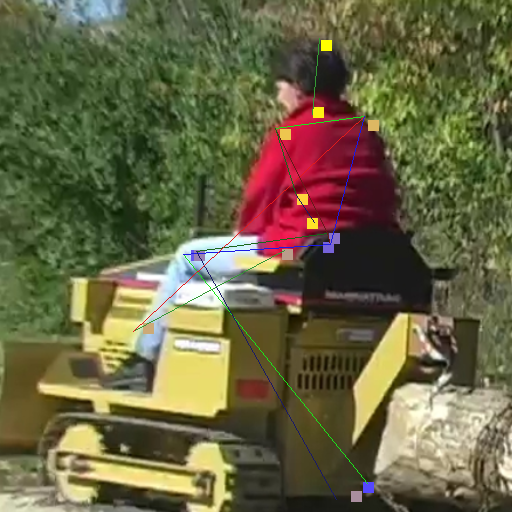

****** PART PREDICTIONS ******


In [31]:
visualize_part_detection_results(deeper_cut_with_loc_ref, 
dval_29, visualization_idxs = 3280:3283; 
    focus_on_argmax = true,
    add_loc_ref_offset = true,
    show_body_skeleton = true, 
should_color_scmap_for_gt = true)

In [51]:
using DataFrames

┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1278


In [111]:
df = DataFrame( 
    
    Ankle1 = Float32[],
    Knee1 = Float32[],
    Hip1 = Float32[],
    Hip2 = Float32[],
    Knee2 = Float32[],
    Ankle2 = Float32[],
    Wrist1 = Float32[],
    Elbow1 = Float32[],
    Shoulder1 = Float32[],
    Shoulder2 = Float32[],
    Elbow2 = Float32[],
    Wrist2 = Float32[],
    Chin = Float32[],
    TopHead = Float32[],
)

,Ankle1,Knee1,Hip1,Hip2,Knee2,Ankle2,Wrist1,Elbow1,Shoulder1
,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32


In [112]:
for i in 1:size(t, 1)
    push!(df, t[i, :])
end

In [113]:
df

,Ankle1,Knee1,Hip1,Hip2,Knee2,Ankle2,Wrist1,Elbow1,Shoulder1
,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.59,5.66,4.73,4.21,6.69,7.81,9.53,10.38,13.1
5,7.63,7.0,4.34,3.9,6.39,6.8,10.1,10.13,12.22
6,7.61,6.12,4.6,4.11,6.59,7.46,9.72,10.3,12.8
7,21.86,19.93,15.93,15.87,19.97,21.05,30.08,30.69,36.86
8,22.18,19.26,16.05,15.03,18.85,20.41,24.15,28.56,35.19
9,21.97,19.7,15.97,15.59,19.58,20.82,28.09,29.97,36.3


In [115]:
using CSV

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1278


In [117]:
CSV.write("29-12-resnet_50_results.csv", df)

"29-12-resnet_50_results.csv"